[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Komatsu-T/Samples/blob/main/deep_learning/computer_vision/variational_auto_encoder/Conditional_VAE.ipynb)

# Conditional VAE (MNIST dataset)

In [2]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10

In [3]:
# --------------------------------------------------
# Device
# --------------------------------------------------
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

!nvidia-smi

cuda
Sat Jun 15 09:42:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [3]:
# --------------------------------------------------
# Settings
# --------------------------------------------------
batch_size = 150
epochs = 50
lr = 1e-3
weight_decay = 0

In [4]:
# --------------------------------------------------
# Dataset
# --------------------------------------------------

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Datset
train_dataset = torchvision.datasets.MNIST(root = './train', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST(root = './test', train = False, transform = transform, download = True)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35145967.39it/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1210630.56it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9548643.34it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7556734.93it/s]

Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37722336.82it/s]


Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1226330.43it/s]

Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9886497.05it/s]


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3813156.28it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



In [5]:
# --------------------------------------------------
# Model
# --------------------------------------------------

class UnFlatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input.view(-1, input.size()[-1], 1, 1)

class ConditionalVAE(nn.Module):
    def __init__(self, d_latent):
        super().__init__()

        # Label processing for encoder
        self.fc_label = nn.Sequential(
            nn.Linear(10, 28*28)
        )

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, stride = 1, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, stride = 2, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, stride = 2, kernel_size = 3, padding = 0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Fully connected layer for mean and log-variance of latent space
        self.fc_mu = nn.Linear(128, d_latent)
        self.fc_logvar = nn.Linear(128, d_latent)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_latent+10, 128),
            UnFlatten(),
            nn.ConvTranspose2d(128, 64, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = 5, stride = 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = 4, stride = 2),
            nn.Sigmoid()
        )

    def label_embed(self, x, y):
        labels = torch.zeros((x.size()[0], 10))
        labels[np.arange(x.size()[0]), y] = 1
        labels = labels.to(device)
        label_embedding = self.fc_label(labels)
        label_embedding = label_embedding.view(-1, 28, 28).unsqueeze(1)
        return labels, label_embedding

    def encode(self, x, label_embedding):
        encoder_input = torch.cat((x, label_embedding), dim = 1)
        h = self.encoder(encoder_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(logvar)
        z = mu + (eps*std)
        return z

    def decode(self, z, label_onehot):
        decoder_input = torch.cat([z, label_onehot], dim = 1)
        decoded_image = self.decoder(decoder_input)
        return decoded_image

    def forward(self, x, y):
        label_onehot, label_embedding = self.label_embed(x, y)
        mu, logvar = self.encode(x, label_embedding)
        z = self.reparameterize(mu, logvar)
        decoded_image = self.decode(z, label_onehot)
        return decoded_image, mu, logvar

In [6]:
# --------------------------------------------------
# Loss function
# --------------------------------------------------

class VAELoss(nn.Module):
    def __init__(self, KLDWeight = 1):
        super().__init__()
        self.KLDWeight = KLDWeight

    def forward(self, decoded_input, input, mu, logvar):
        BCE = F.binary_cross_entropy(decoded_input, input, reduction = 'sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.KLDWeight*KLD

In [9]:
# --------------------------------------------------
# Instantiation of pytorch components
# --------------------------------------------------

# Model
model = ConditionalVAE(32)
model = model.to(device)

# Loss function
criterion = VAELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

[Epoch 50/50]: 100%|██████████| 400/400 [00:11<00:00, 34.44it/s]


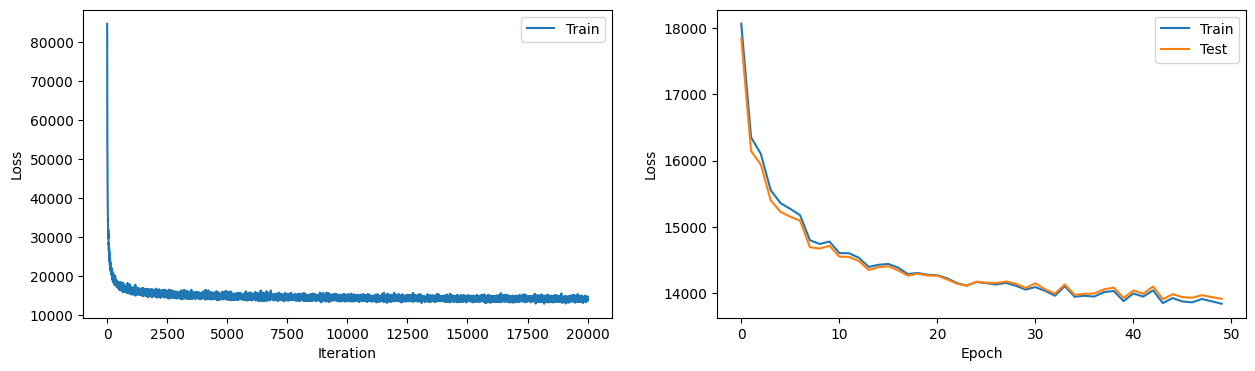

In [9]:
# --------------------------------------------------
# Training
# --------------------------------------------------

train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []
for epoch in range(epochs):

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch {epoch+1}/{epochs}]')

        # Training step
        model.train()
        for x, y in pbar:
            x = x.to(device)
            y = y.to(device)
            decoded_x, mu, logvar = model(x, y)
            loss = criterion(decoded_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_minibatch.append(loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            # Train loss
            losses = []
            for x, y in train_loader:
                x = x.to(device)
                y = y.to(device)
                decoded_x, mu, logvar = model(x, y)
                loss = criterion(decoded_x, x, mu, logvar)
                losses.append(loss.item())
            train_loss_epoch.append(np.mean(losses))

            # Test loss
            losses = []
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                decoded_x, mu, logvar = model(x, y)
                loss = criterion(decoded_x, x, mu, logvar)
                losses.append(loss.item())
            test_loss_epoch.append(np.mean(losses))

# Loss plot
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(train_loss_epoch, label = "Train")
ax[1].plot(test_loss_epoch, label = "Test")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].legend()
plt.show()

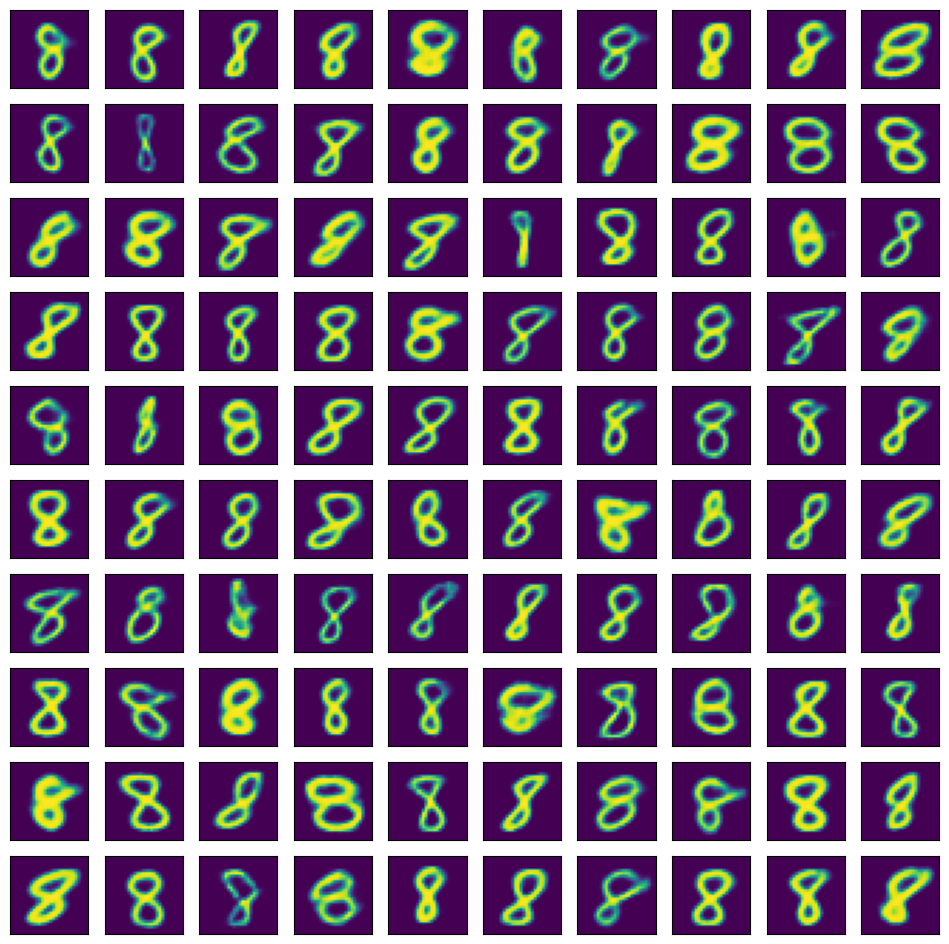

In [157]:
# --------------------------------------------------
# Image generation from N(0,1) samples
# --------------------------------------------------

def image_generation(target, d_latenr = 32, num_image = 100):
    # Sampling from N(0,1)
    z = torch.randn((num_image, d_latenr)).to(device)
    # Onehot-encoding of target label
    label_onehot = torch.zeros((num_image, 10))
    label_onehot[:,target] = 1
    label_onehot = label_onehot.to(device)
    # Image generation
    image = model.decode(z, label_onehot)
    return image.cpu().detach().numpy()

# Show image
model.eval()
with torch.no_grad():
    generated_images = image_generation(8)

fig, ax = plt.subplots(10, 10, figsize = (12, 12))
ax = ax.ravel()
for i in range(generated_images.shape[0]):
    ax[i].imshow(generated_images[i][0])
    ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
plt.show()

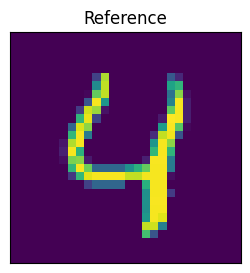

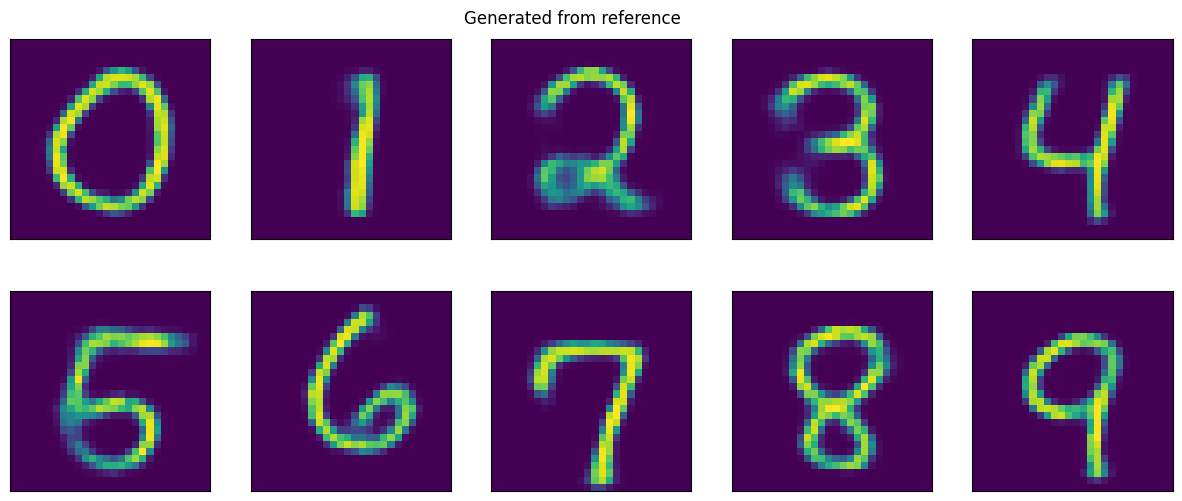

In [188]:
# --------------------------------------------------
# Image generation (copy handwriting)
# --------------------------------------------------

#num = 495
num = 4
model.eval()
with torch.no_grad():
    # Reference image
    reference_image, reference_label = test_dataset[num]
    reference_image = reference_image.unsqueeze(0).to(device)
    reference_label = torch.IntTensor([reference_label]).to(device)

    plt.figure(figsize = (3, 3))
    plt.imshow(reference_image.cpu().detach().numpy()[0][0])
    plt.tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.title("Reference")
    plt.show()

    # Latent vector of reference image
    _, reference_label_embedding = model.label_embed(reference_image, reference_label)
    mu, logvar = model.encode(reference_image, reference_label_embedding)
    reference_z = model.reparameterize(mu, logvar)

    # Image generation
    fig, ax = plt.subplots(2, 5, figsize = (15, 6))
    ax = ax.ravel()
    for i in range(10):
        # Onehot-encoding of target label
        label_onehot = torch.zeros((1, 10))
        label_onehot[:,i] = 1
        label_onehot = label_onehot.to(device)
        # Decode
        generated_image = model.decode(reference_z, label_onehot).cpu().detach().numpy()
        # Plot
        ax[i].imshow(generated_image[0][0])
        ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.suptitle("Generated from reference", y = 0.92)
    plt.show()